In [1]:
pip install --upgrade google-meridian

  Using cached google_meridian-1.1.5-py3-none-any.whl.metadata (22 kB)
  Attempting uninstall: google-meridian
    Found existing installation: google-meridian 1.1.4
    Uninstalling google-meridian-1.1.4:
      Successfully uninstalled google-meridian-1.1.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import input_data
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 8.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [3]:
pddata = pd.read_csv('dataset/m-blue.csv')

In [22]:
coord_to_columns = load.CoordToColumns(
    time='date',
    controls=['percent_share_of_sales_value_product', 'competitor_KTD_S', 'competitor_Carabao_S'],
    kpi='total_sales',
    media=[
        'kol_S',
        'tv_spot_S',
        'tv_sponsor_S',
        'radio_S',
        'activation_S',
        'facebook_S',
        'youtube_S',
        'tiktok_S',
        'kol_boost_S'
    ],
    media_spend=[
        'kol_S',
        'tv_spot_S',
        'tv_sponsor_S',
        'radio_S',
        'activation_S',
        'facebook_S',
        'youtube_S',
        'tiktok_S',
        'kol_boost_S'
    ],
)

In [23]:
correct_media_to_channel = {
        'kol_S': 'kol',
        'tv_spot_S': 'tv_spot',
        'tv_sponsor_S': 'tv_sponsor',
        'radio_S': 'radio',
        'activation_S': 'activation',
        'facebook_S': 'facebook',
        'youtube_S': 'youtube',
        'tiktok_S' : 'tiktok',
        'kol_boost_S': 'kol_boost'
}

correct_media_spend_to_channel = {
        'kol_S': 'kol',
        'tv_spot_S': 'tv_spot',
        'tv_sponsor_S': 'tv_sponsor',
        'radio_S': 'radio',
        'activation_S': 'activation',
        'facebook_S': 'facebook',
        'youtube_S': 'youtube',
        'tiktok_S' : 'tiktok',
        'kol_boost_S': 'kol_boost'
}

In [30]:
loader = load.CsvDataLoader(
    csv_path=f'dataset/m-blue.csv',
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
)

data = loader.load()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/data/input_data.py:463: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [31]:
#functiom to translate the media ROI into a log normal distribution usable by the model prios

def estimate_lognormal_dist(mean, std):
    """
    Reparameterizes the LogNormal distribution in terms of its mean and std.
    Returns mu_log and std_log which can be used to define a LogNormal.
    """
    mu_log = np.log(mean) - 0.5 * np.log((std/mean)**2 + 1)
    std_log = np.sqrt(np.log((std/mean)**2 + 1))
    return mu_log, std_log

roi_mu= 5
roi_sigma= 4.5

roi_mu_log, roi_sigma_log=estimate_lognormal_dist(roi_mu, roi_sigma)
print(roi_mu_log, roi_sigma_log)

pddata = pd.read_csv('dataset/m-blue.csv')

# setting priors based on spend share
total_spend= pddata[['kol_S', 'tv_spot_S', 'tv_sponsor_S', 'radio_S', 'activation_S', 'facebook_S', 'youtube_S', 'tiktok_S', 'kol_boost_S']].sum().sum()
priors={'mu':[], 'sigma':[]}
for i in ['kol_S', 'tv_spot_S', 'tv_sponsor_S', 'radio_S', 'activation_S', 'facebook_S', 'youtube_S', 'tiktok_S', 'kol_boost_S']:
  spend_share=(pddata[i].sum()/total_spend)*2
  roi_sigma=roi_mu*spend_share
  mu , sigma= estimate_lognormal_dist(roi_mu, roi_sigma)
  priors['mu'].append(mu)
  priors['sigma'].append(sigma)

print(priors)

roi_mu=priors['mu']
roi_sigma=priors['sigma']
print(roi_mu)


1.3127744897952331 0.7702771223902047
{'mu': [np.float64(1.5842123248080453), np.float64(1.4935743959075076), np.float64(1.6093237704651246), np.float64(1.598919711937041), np.float64(1.4672089089583606), np.float64(1.5617670053277524), np.float64(1.5910938906681735), np.float64(1.6094199747028528), np.float64(1.6093689918211203)], 'sigma': [np.float64(0.22461339063401803), np.float64(0.4813803413655209), np.float64(0.015109068070247058), np.float64(0.14503930844470503), np.float64(0.5333460480321188), np.float64(0.30877469814202013), np.float64(0.19154123193676426), np.float64(0.005989612883546311), np.float64(0.011740580307628999)]}
[np.float64(1.5842123248080453), np.float64(1.4935743959075076), np.float64(1.6093237704651246), np.float64(1.598919711937041), np.float64(1.4672089089583606), np.float64(1.5617670053277524), np.float64(1.5910938906681735), np.float64(1.6094199747028528), np.float64(1.6093689918211203)]


In [32]:
# Convert numpy float64 values to TensorFlow float32 tensors
roi_mu = [tf.convert_to_tensor(m, dtype=tf.float32) for m in roi_mu]
roi_sigma = [tf.convert_to_tensor(s, dtype=tf.float32) for s in roi_sigma]

# Build media channel arguments
build_media_channel_args = data.get_paid_media_channels_argument_builder()

# Pass the converted tensors
roi_m = build_media_channel_args(
    kol=(roi_mu[0], roi_sigma[0]),
    tv_spot=(roi_mu[1], roi_sigma[1]),
    tv_sponsor=(roi_mu[2], roi_sigma[2]),
    radio=(roi_mu[3], roi_sigma[3]),
    activation=(roi_mu[4], roi_sigma[4]),
    facebook=(roi_mu[5], roi_sigma[5]),
    youtube=(roi_mu[6], roi_sigma[6]),
    tiktok=(roi_mu[7], roi_sigma[7]),
    kol_boost=(roi_mu[8], roi_sigma[8]),
)

roi_m_mu, roi_m_sigma = zip(*roi_m)

# Convert to TensorFlow tensors
roi_m_mu = tf.stack(roi_m_mu)
roi_m_sigma = tf.stack(roi_m_sigma)

# Create prior distribution
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_m_mu, roi_m_sigma, name=constants.ROI_M),
)

In [33]:
np.random.seed(1)
test_pct = 0.2  # 20% holdout
n_times = len(data.time)

# Create a 1D boolean array of length n_times
holdout_id = np.full(n_times, False)
holdout_indices = np.random.choice(n_times, int(np.round(test_pct * n_times)), replace=False)
holdout_id[holdout_indices] = True

# Pass it into the model spec
model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout_id
)


In [35]:
#%%time

mmm = model.Meridian(input_data=data, model_spec=model_spec)
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time

# ... (rest of your imports and code) ...

with tqdm(total=5*1000, desc="Training Progress") as pbar:  # Total iterations
    def update_progress(current_iteration, total_iterations):
        pbar.update(current_iteration)  # Update the progress bar

    # Remove progress_callback from the sample_posterior call
    mmm.sample_posterior(
        n_chains=5,
        n_adapt=500,
        n_burnin=500,
        n_keep=1000,
        parallel_iterations=100,
        # progress_callback=update_progress  # Remove this line
    )
    # Manually update progress bar after sampling
    pbar.update(5 * 1000)

#n_chains: Markov Chain Monte Carlo (MCMC) indipendent chains
#n_adapt: number of initial samples used to tune the sampling algorithm for better performance
#n_burnin: number of initial samples from each chain that are discarded
#n_keep: number of samples to keep from each chain after the burn-in phase. These samples represent the posterior distribution of the model parameters and are used for inference.

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has b

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

W0000 00:00:1752467875.343731  678291 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [36]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

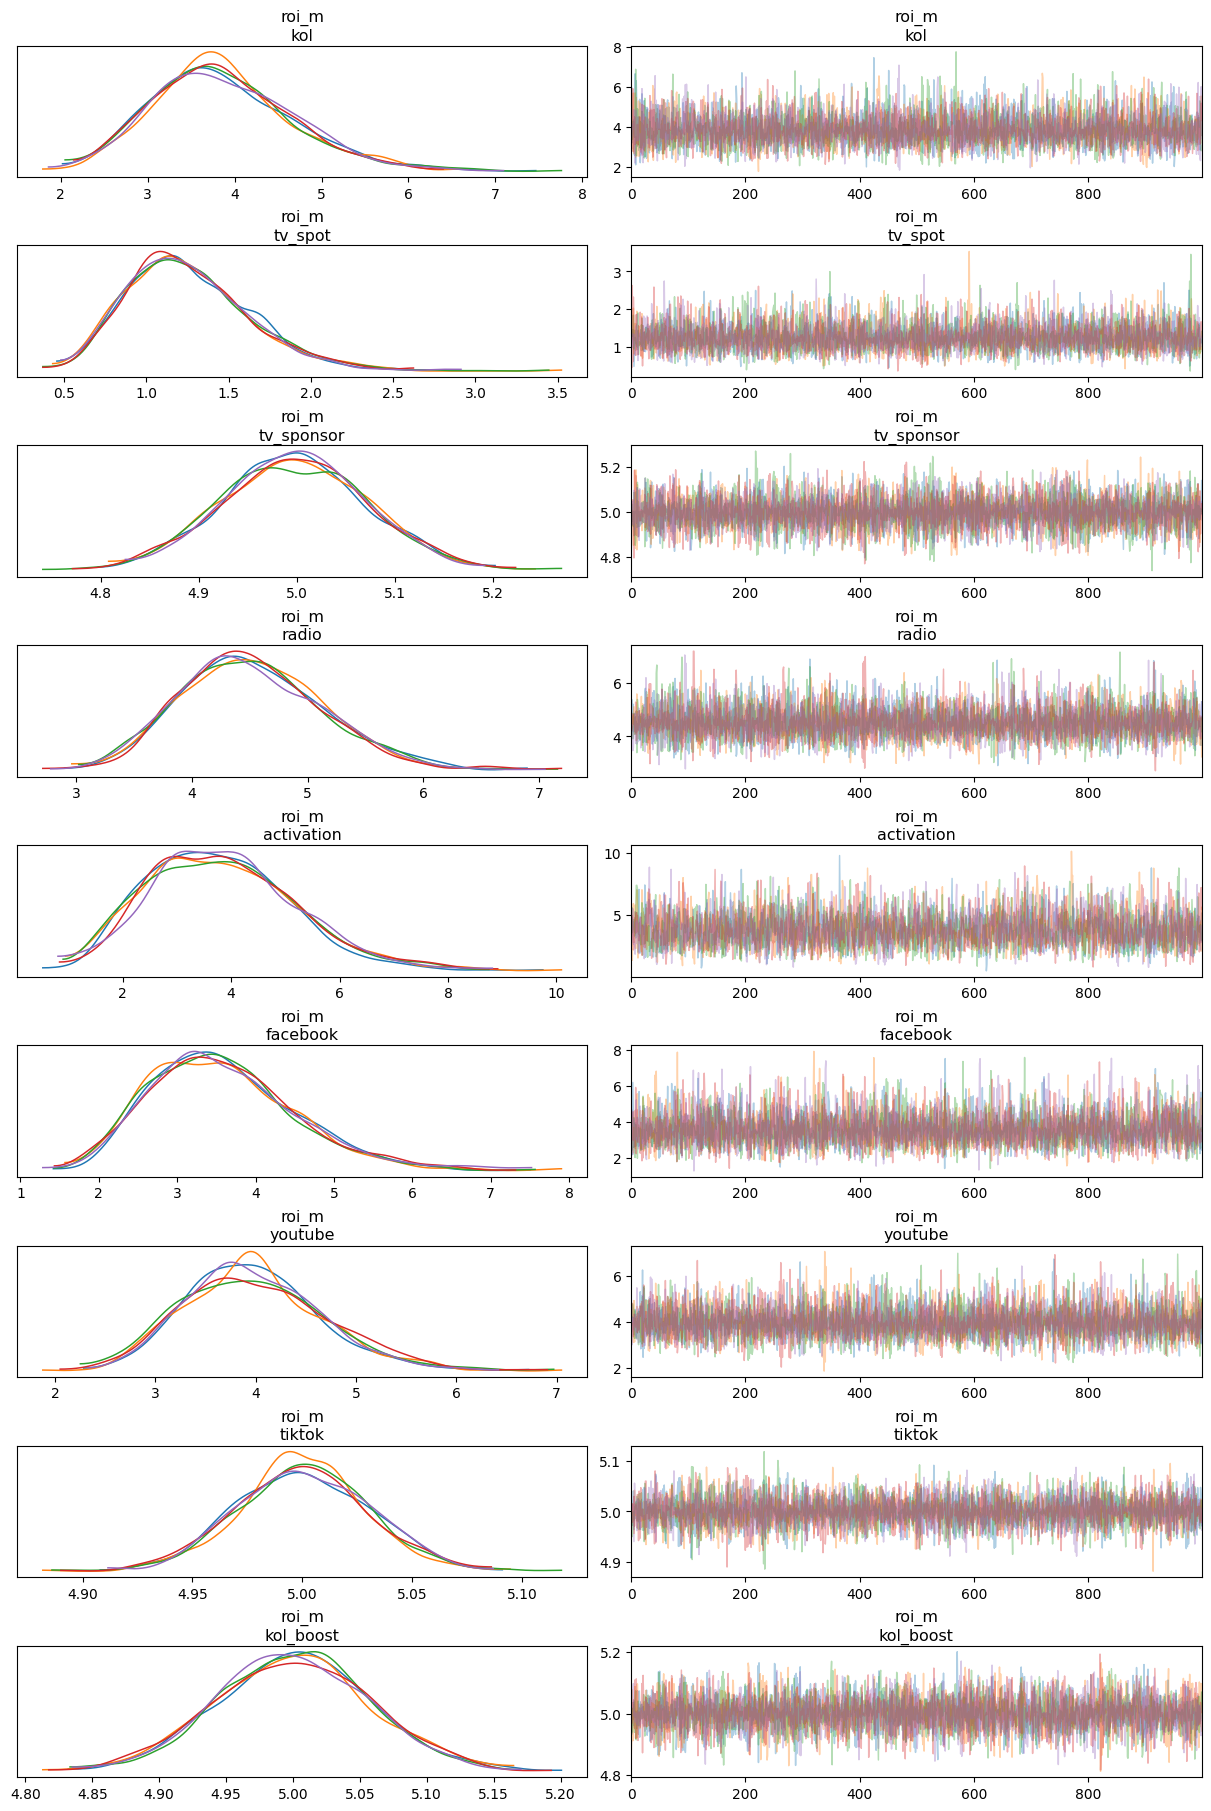

In [37]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [38]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_prior_and_posterior_distribution()

alt.FacetChart(...)

In [39]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [40]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:889: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/visualizer.py:1629: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


channel distribution impressions % impressions        spend % spend  \
0            kol        prior   5,140,650         11.4%   $5,140,650   11.4%   
1            kol    posterior   5,140,650         11.4%   $5,140,650   11.4%   
2        tv_spot        prior  11,540,248         25.5%  $11,540,248   25.5%   
3        tv_spot    posterior  11,540,248         25.5%  $11,540,248   25.5%   
4     tv_sponsor        prior     341,463          0.8%     $341,463    0.8%   
5     tv_sponsor    posterior     341,463          0.8%     $341,463    0.8%   
6          radio        prior   3,295,000          7.3%   $3,295,000    7.3%   
7          radio    posterior   3,295,000          7.3%   $3,295,000    7.3%   
8     activation        prior  12,963,048         28.7%  $12,963,048   28.7%   
9     activation    posterior  12,963,048         28.7%  $12,963,048   28.7%   
10      facebook        prior   7,147,552         15.8%   $7,147,552   15.8%   
11      facebook    posterior   7,147,552         15.8%   $7,147,552   15.8%   
12       youtube        prior   4,368,572          9.7%   $4,368,572    9.7%   
13       youtube    posterior   4,368,572          9.7%   $4,368,572    9.7%   
14        tiktok        prior     135,358          0.3%     $135,358    0.3%   
15        tiktok    posterior     135,358          0.3%     $135,358    0.3%   
16     kol_boost        prior     265,330          0.6%     $265,330    0.6%   
17     kol_boost    posterior     265,330          0.6%     $265,330    0.6%   
18  All Channels        prior  45,197,216        100.0%  $45,197,216  100.0%   
19  All Channels    posterior  45,197,216        100.0%  $45,197,216  100.0%   

       cpm                        incremental outcome        % contribution  \
0   $1,000     $25,833,700 ($17,320,132, $36,160,784)     1.8% (1.2%, 2.5%)   
1   $1,000     $19,866,100 ($13,676,664, $27,378,788)     1.6% (1.1%, 2.3%)   
2   $1,000    $57,242,212 ($23,170,296, $107,141,392)     4.0% (1.6%, 7.5%)   
3   $1,000      $14,483,313 ($8,396,239, $22,184,370)     1.2% (0.7%, 1.8%)   
4   $1,000        $1,707,781 ($1,663,924, $1,749,302)     0.1% (0.1%, 0.1%)   
5   $1,000        $1,706,650 ($1,665,168, $1,748,550)     0.1% (0.1%, 0.1%)   
6   $1,000     $16,542,631 ($12,874,612, $20,866,636)     1.2% (0.9%, 1.5%)   
7   $1,000     $14,916,628 ($11,810,423, $18,491,170)     1.2% (1.0%, 1.5%)   
8   $1,000    $65,840,772 ($24,709,804, $139,583,776)     4.6% (1.7%, 9.8%)   
9   $1,000     $49,697,312 ($23,874,362, $80,840,304)     4.1% (2.0%, 6.7%)   
10  $1,000     $35,917,868 ($19,855,932, $55,723,740)     2.5% (1.4%, 3.9%)   
11  $1,000     $25,648,736 ($16,068,268, $38,005,996)     2.1% (1.3%, 3.1%)   
12  $1,000     $21,851,688 ($15,868,724, $28,928,972)     1.5% (1.1%, 2.0%)   
13  $1,000     $17,402,620 ($12,883,810, $22,796,928)     1.4% (1.1%, 1.9%)   
14  $1,000              $676,916 ($670,079, $683,753)     0.0% (0.0%, 0.0%)   
15  $1,000              $676,812 ($670,281, $683,498)     0.1% (0.1%, 0.1%)   
16  $1,000        $1,326,753 ($1,298,977, $1,351,155)     0.1% (0.1%, 0.1%)   
17  $1,000        $1,326,770 ($1,302,048, $1,352,180)     0.1% (0.1%, 0.1%)   
18  $1,000  $226,940,304 ($162,231,264, $313,258,560)  16.0% (11.4%, 22.0%)   
19  $1,000  $145,724,864 ($114,971,960, $181,645,968)   12.0% (9.5%, 15.0%)   

                roi       effectiveness            mroi               cpik  
0    5.0 (3.4, 7.0)   5.03 (3.37, 7.03)  2.7 (1.3, 4.3)  $0.2 ($0.1, $0.3)  
1    3.9 (2.7, 5.3)   3.86 (2.66, 5.33)  1.9 (0.8, 3.2)  $0.3 ($0.2, $0.4)  
2    5.0 (2.0, 9.3)   4.96 (2.01, 9.28)  2.4 (0.7, 5.1)  $0.2 ($0.1, $0.5)  
3    1.3 (0.7, 1.9)   1.26 (0.73, 1.92)  0.6 (0.2, 1.1)  $0.8 ($0.5, $1.4)  
4    5.0 (4.9, 5.1)   5.00 (4.87, 5.12)  2.9 (1.4, 4.0)  $0.2 ($0.2, $0.2)  
5    5.0 (4.9, 5.1)   5.00 (4.88, 5.12)  3.0 (1.5, 4.0)  $0.2 ($0.2, $0.2)  
6    5.0 (3.9, 6.3)   5.02 (3.91, 6.33)  1.6 (0.8, 2.5)  $0.2 ($0.2, $0.3)  
7    4.5 (3.6, 5.6)   4.53 (3.58, 5.61)  1.4 (0.7, 2

In [41]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


metric geo_granularity evaluation_set     value
0  R_Squared        national          Train  0.941495
1  R_Squared        national           Test  0.804751
2  R_Squared        national       All Data  0.931794
3       MAPE        national          Train  2.385127
4       MAPE        national           Test  0.134866
5       MAPE        national       All Data  1.930747
6      wMAPE        national          Train  0.115325
7      wMAPE        national           Test  0.118643
8      wMAPE        national       All Data  0.116174

In [42]:
filepath = './output'  # or any local directory you want
start_date = '2022-07-04'
end_date = '2024-06-24'

mmm_summarizer = summarizer.Summarizer(mmm)

# Make sure the directory exists
import os
os.makedirs(filepath, exist_ok=True)

mmm_summarizer.output_model_results_summary('new_summary_output.html', filepath, start_date, end_date)

# To display in VS Code Jupyter notebook output
#from IPython.display import HTML
#HTML(filename=os.path.join(filepath, 'summary_output.html'))


/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:3103: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:889: UserWarning: Setting `use_kpi=True` has no effect 

In [43]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)

build_channel_args = mmm.input_data.get_paid_channels_argument_builder()

optimization_results = budget_optimizer.optimize(
      selected_times=('2022-07-04', '2024-06-24'),
)

/var/folders/j5/rxb3ttd52vj7syxs52r9z_zm0000gn/T/ipykernel_7919/2057672776.py:5: DeprecationWarning: `selected_times` is deprecated. Please use `start_date` and `end_date` instead.
  optimization_results = budget_optimizer.optimize(


In [44]:
optimization_results.output_optimization_summary('new_optimization_output.html', filepath)
#IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')